In [1]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [2]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/train'  # Update with your actual path
test_dir = '/content/drive/MyDrive/test'    # Update with your actual path

In [3]:
import os
print(len(os.listdir('/content/drive/MyDrive/train/camel')))
print(len(os.listdir('/content/drive/MyDrive/train/horse')))
print(len(os.listdir('/content/drive/MyDrive/test/camel')))
print(len(os.listdir('/content/drive/MyDrive/test/horse')))

144
144
20
20


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. dogs)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 232 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [5]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top = False, #because i have my own image of a diff dimension
                                                input_shape = (256,256,3),
                                                pooling = 'max', classes = 2,
                                                weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 is not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 1s 0us/step


In [6]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [7]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [8]:
history = resnet_model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
8/8 [==============================] - 119s 13s/step - loss: 2.9970 - accuracy: 0.5431 - val_loss: 0.6436 - val_accuracy: 0.6250
Epoch 2/3
8/8 [==============================] - 80s 10s/step - loss: 1.4758 - accuracy: 0.6293 - val_loss: 0.6967 - val_accuracy: 0.6607
Epoch 3/3
8/8 [==============================] - 84s 11s/step - loss: 0.8771 - accuracy: 0.6121 - val_loss: 0.7106 - val_accuracy: 0.6250


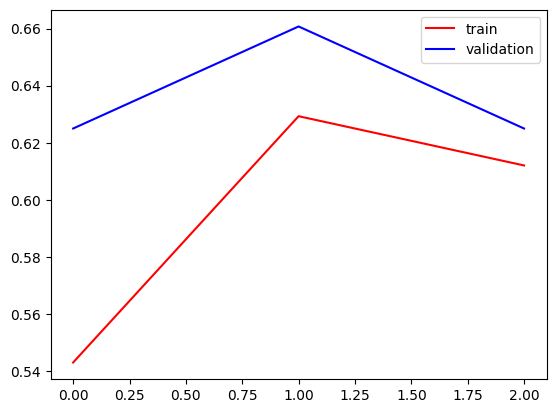

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

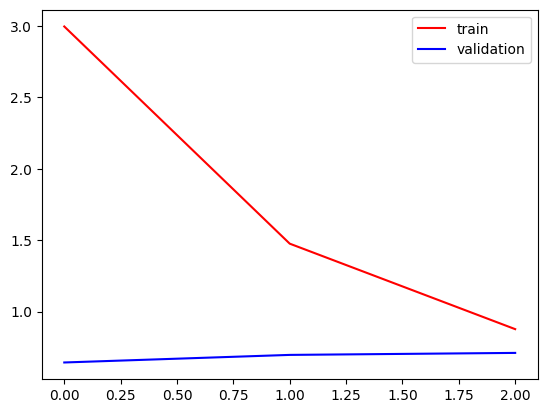

In [10]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 40 images belonging to 2 classes.


In [12]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

2/2 [==============================] - 13s 2s/step
[[0.1736192 ]
 [0.5379989 ]
 [0.7343952 ]
 [0.9955507 ]
 [0.19578853]
 [0.32382908]
 [0.13236734]
 [0.1512577 ]
 [0.9269156 ]
 [0.65750027]
 [0.9417326 ]
 [0.08848315]
 [0.5909694 ]
 [0.1664803 ]
 [0.9997714 ]
 [0.7570304 ]
 [0.45464918]
 [0.1327252 ]
 [0.66715026]
 [0.4644304 ]
 [0.448328  ]
 [0.20981139]
 [0.22108732]
 [0.2559779 ]
 [0.8888666 ]
 [0.73658293]
 [0.92547596]
 [0.969782  ]
 [0.19815339]
 [0.19461074]
 [0.84909797]
 [0.8950397 ]
 [0.86845636]
 [0.23120084]
 [0.9624112 ]
 [0.7335136 ]
 [0.98061043]
 [0.09227771]
 [0.92750514]
 [0.11281451]]


In [13]:
len(predictions)

40

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[10 10]
 [ 9 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        20
           1       0.52      0.55      0.54        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40

